In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer, TokenizedResult
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "048"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [ ]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = False

expected_tokens = 900  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.3)
wandb.config["lr"] = lr = 6e-6
wandb.config["betas"] = betas = (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.1
model = models.qwen_14b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [5]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
prev_deferred_results: list[list[TokenizedResult]] | None = None
i = 0
vllm = await start_vllm(
    model_name,
    max_concurrent_requests=1024,
    env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=1024,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=240 + 15 * torch.cuda.device_count(),
    verbosity=verbosity,
)
semaphore = asyncio.Semaphore(int(1.33 * vllm.max_concurrent_tokens / expected_tokens))
offset = i * stride
val_results, train_results = await asyncio.gather(
    get_task_results(
        tasks=val_tasks,
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=8,
        n=2,
        on_chunk=inference_early_stop,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="val",
        semaphore=semaphore,
    ),
    get_task_results(
        tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=False,
        n=samples_per_task,
        on_chunk=inference_early_stop,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="train",
        semaphore=semaphore,
        transform=TaskResultTokenizer(tokenizer),
    ),
)
vllm.process.terminate()
kill_vllm_workers()
val_stats = val_results.stats
assert val_stats.grades > 0
assert val_stats.usages > 0
wandb_data = {
    "iteration": i,
    "exceptions": val_stats.exceptions + train_results.stats.exceptions,
    "reward": val_stats.total_reward / val_stats.grades,
    "tokens": round(val_stats.completion_tokens / val_stats.usages),
}
for metric in val_stats.total_metrics:
    wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
try:
    wandb_data.update(
        pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
    )
except Exception:
    pass
wandb.log(wandb_data)
expected_tokens = wandb_data["tokens"]
try:
    best_iteration = (
        wandb.Api()
        .run(f"{run.entity}/{run.project}/{run.id}")
        .history()
        .sort_values(by="reward")["iteration"]
        .iloc[-1]
    )
    clear_iteration_dirs(output_dir, [best_iteration, i])
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
except Exception:
    pass
# Deferred results
train_results, deferred_results = (
    train_results[: len(train_results) // 2],
    train_results[len(train_results) // 2 :],
)
if prev_deferred_results is not None:
    for _deferred_results, _train_results in zip(prev_deferred_results, train_results):
        mean_reward = (
            torch.tensor([result.reward for result in _train_results]).mean().item()
        )
        differences = [mean_reward - result.reward for result in _deferred_results]
        std_dev = torch.std(torch.tensor(differences)).item()
        for result, difference in zip(_deferred_results, differences):
            result.advantage = difference / std_dev
            result.deferred = True
    random.shuffle(prev_deferred_results)
    random.shuffle(train_results)
    train_results = prev_deferred_results + train_results
else:
    random.shuffle(train_results)
prev_deferred_results = deferred_results

$ vllm serve Qwen/Qwen2.5-14B-Instruct --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --port=8000 --api-key=default
INFO 02-25 14:58:49 __init__.py:190] Automatically detected platform cuda.
INFO 02-25 14:58:50 api_server.py:840] vLLM API server version 0.7.2
INFO 02-25 14:58:50 api_server.py:841] args: Namespace(subparser='serve', model_tag='Qwen/Qwen2.5-14B-Instruct', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:03,  1.77it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.74it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:02,  1.72it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:01<00:01,  2.34it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.09it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:00,  2.04it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.87it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.80it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.89it/s]



INFO 02-25 14:59:47 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=10950) INFO 02-25 14:59:47 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=10950) INFO 02-25 14:59:50 worker.py:267] Memory profiling takes 2.89 seconds
(VllmWorkerProcess pid=10950) INFO 02-25 14:59:50 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=10950) INFO 02-25 14:59:50 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-25 14:59:50 worker.py:267] Memory profiling takes 2.92 seconds
INFO 02-25 14:59:50 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-25 14:59:50 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [10648]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-25 15:00:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:47216 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [16:05<00:00,  1.82it/s, completion_tokens=894, prompt_tokens=1495, reward=0.276, acc=0.276, early_stop=0.035, token_logprobs=2839818]


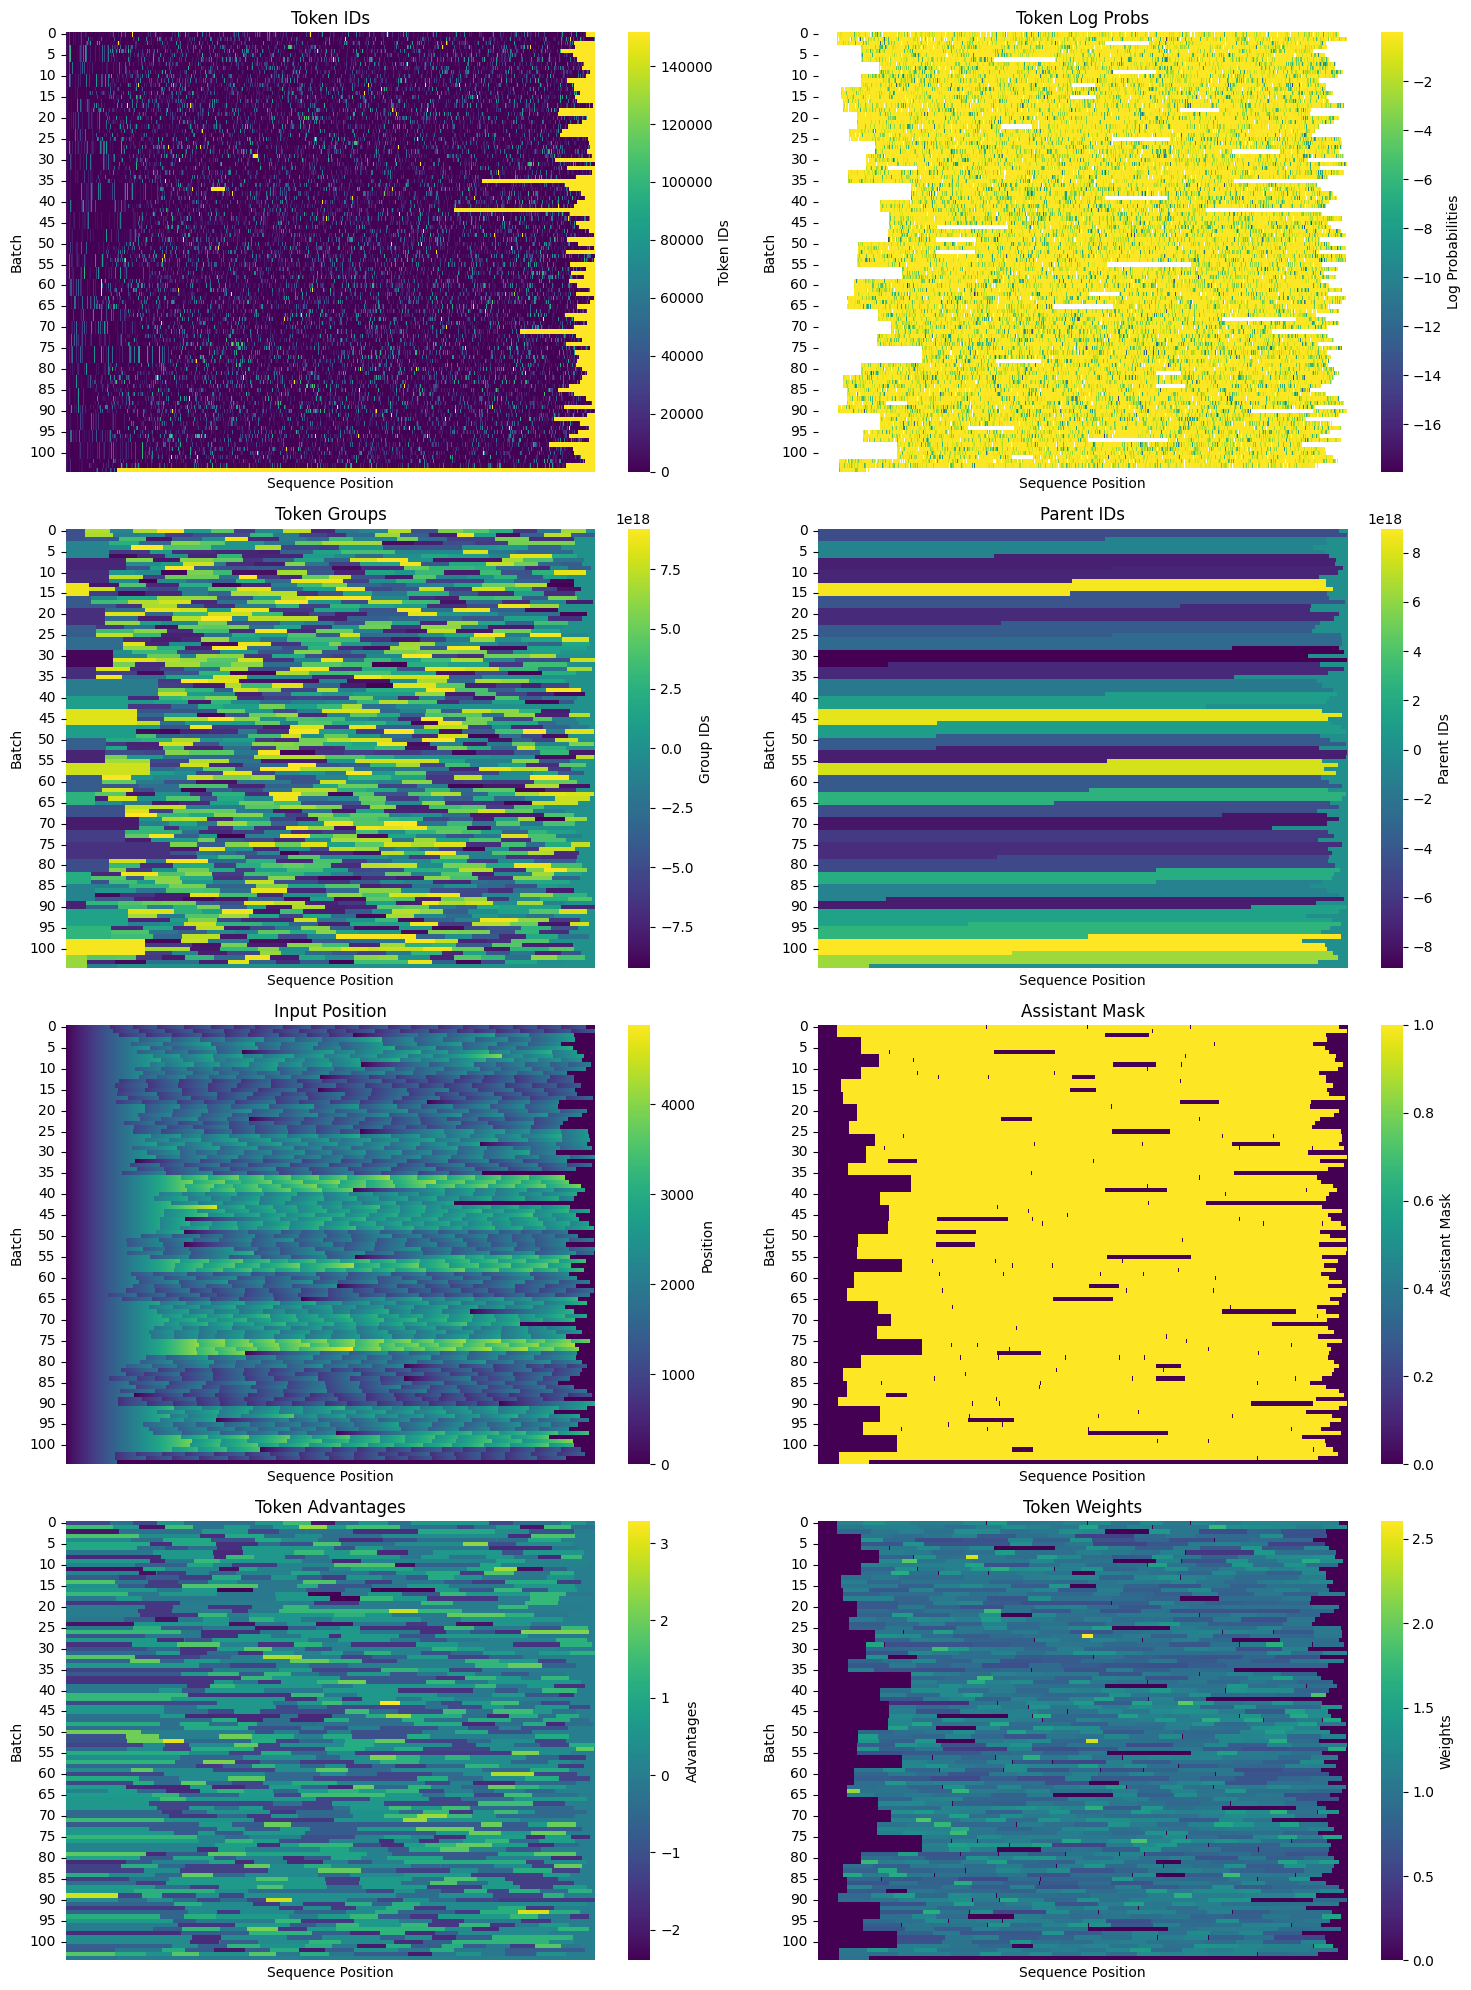

Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/6634c8cc3133b3848ec74b9f275acaaa1ea618ab
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/cdb53558f3d3871db6823dd95ecac029044757a0
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/048/config.yaml
Running with torchrun...


W0225 15:19:21.903000 14420 torch/distributed/run.py:793] 
W0225 15:19:21.903000 14420 torch/distributed/run.py:793] *****************************************
W0225 15:19:21.903000 14420 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0225 15:19:21.903000 14420 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/snapshots/cf98f3b3bbb457ad9e2bb7baf9a

Writing logs to models/048/logs/log_1740496766.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.86 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|26|Loss: -0.0388: 100%|██████████| 26/26 [12:53<00:00, 28.85s/it, entropy=0.767, kl_div=nan, loss=-0.0388, policy=-0.0388]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
I

<Task pending name='Task-8390' coro=<rsync_dir() running at /home/gcpuser/sky_workdir/experiments/lib/utils.py:49>>

rsyncing /home/gcpuser/sky_workdir/experiments/models/048 to gs:/atreides/openpipe/models/048


In [10]:
tokenized_results = [
    result for results in train_results for result in results if result.advantage != 0
]
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results,
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
if verbosity == 2:
    plot_packed_tensors(packed_tensors)
else:
    print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
optimizer_config = ComponentConfig(
    model.tune_optimizer,
    lr=lr,
    betas=betas,
    weight_decay=weight_decay,
)
if model.tune_optimizer == "torch.optim.AdamW":
    optimizer_config.fused = True
model_name = await tune(
    base_model=model.base_model,
    output_dir=output_dir,
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=optimizer_config,
        loss=ComponentConfig(
            GRPO,
            clip_epsilon=clip_epsilon,
            entropy_coef=entropy_coef,
            kl_coef=kl_coef,
            tanh=tanh,
        ),
        # shuffle=True,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=model.tune_num_output_chunks,
        compile=True,
    ),
    verbosity=verbosity,
)
# see ./logs/rsync.log for output
asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))

In [11]:
i = 1
vllm = await start_vllm(
    model_name,
    max_concurrent_requests=1024,
    env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=1024,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=240 + 15 * torch.cuda.device_count(),
    verbosity=verbosity,
)
semaphore = asyncio.Semaphore(int(1.33 * vllm.max_concurrent_tokens / expected_tokens))
offset = i * stride
val_results, train_results = await asyncio.gather(
    get_task_results(
        tasks=val_tasks,
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=8,
        n=2,
        on_chunk=inference_early_stop,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="val",
        semaphore=semaphore,
    ),
    get_task_results(
        tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=False,
        n=samples_per_task,
        on_chunk=inference_early_stop,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="train",
        semaphore=semaphore,
        transform=TaskResultTokenizer(tokenizer),
    ),
)
vllm.process.terminate()
kill_vllm_workers()
val_stats = val_results.stats
assert val_stats.grades > 0
assert val_stats.usages > 0
wandb_data = {
    "iteration": i,
    "exceptions": val_stats.exceptions + train_results.stats.exceptions,
    "reward": val_stats.total_reward / val_stats.grades,
    "tokens": round(val_stats.completion_tokens / val_stats.usages),
}
for metric in val_stats.total_metrics:
    wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
try:
    wandb_data.update(
        pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
    )
except Exception:
    pass
wandb.log(wandb_data)
expected_tokens = wandb_data["tokens"]
try:
    best_iteration = (
        wandb.Api()
        .run(f"{run.entity}/{run.project}/{run.id}")
        .history()
        .sort_values(by="reward")["iteration"]
        .iloc[-1]
    )
    clear_iteration_dirs(output_dir, [best_iteration, i])
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
except Exception:
    pass
# Deferred results
train_results, deferred_results = (
    train_results[: len(train_results) // 2],
    train_results[len(train_results) // 2 :],
)

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/048/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/048/0001 --port=8000 --api-key=default
INFO 02-25 15:35:25 __init__.py:190] Automatically detected platform cuda.
INFO 02-25 15:35:26 api_server.py:840] vLLM API server version 0.7.2
INFO 02-25 15:35:26 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/048/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.67it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.71it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:02,  1.70it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:01<00:01,  2.31it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.29it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:02<00:00,  2.05it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.90it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.83it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.91it/s]



(VllmWorkerProcess pid=18212) INFO 02-25 15:35:45 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-25 15:35:45 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=18212) INFO 02-25 15:35:47 worker.py:267] Memory profiling takes 2.18 seconds
(VllmWorkerProcess pid=18212) INFO 02-25 15:35:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=18212) INFO 02-25 15:35:47 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-25 15:35:47 worker.py:267] Memory profiling takes 2.29 seconds
INFO 02-25 15:35:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-25 15:35:47 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [17899]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-25 15:36:39 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-25 15:36:40 metrics.py:455] Avg prompt throughput: 3.7 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-25 15:36:40 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:33800 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [08:27<00:00, 10.90it/s, completion_tokens=897, prompt_tokens=1334, reward=0.326, acc=0.326, early_stop=0.00875, token_logprobs=2865951]
rsyncing /home/gcpuser/sky_workdir/experiments/models/048 to gs:/atreides/openpipe/models/048


ValueError: num must be an integer with 1 <= num <= 8, not 9

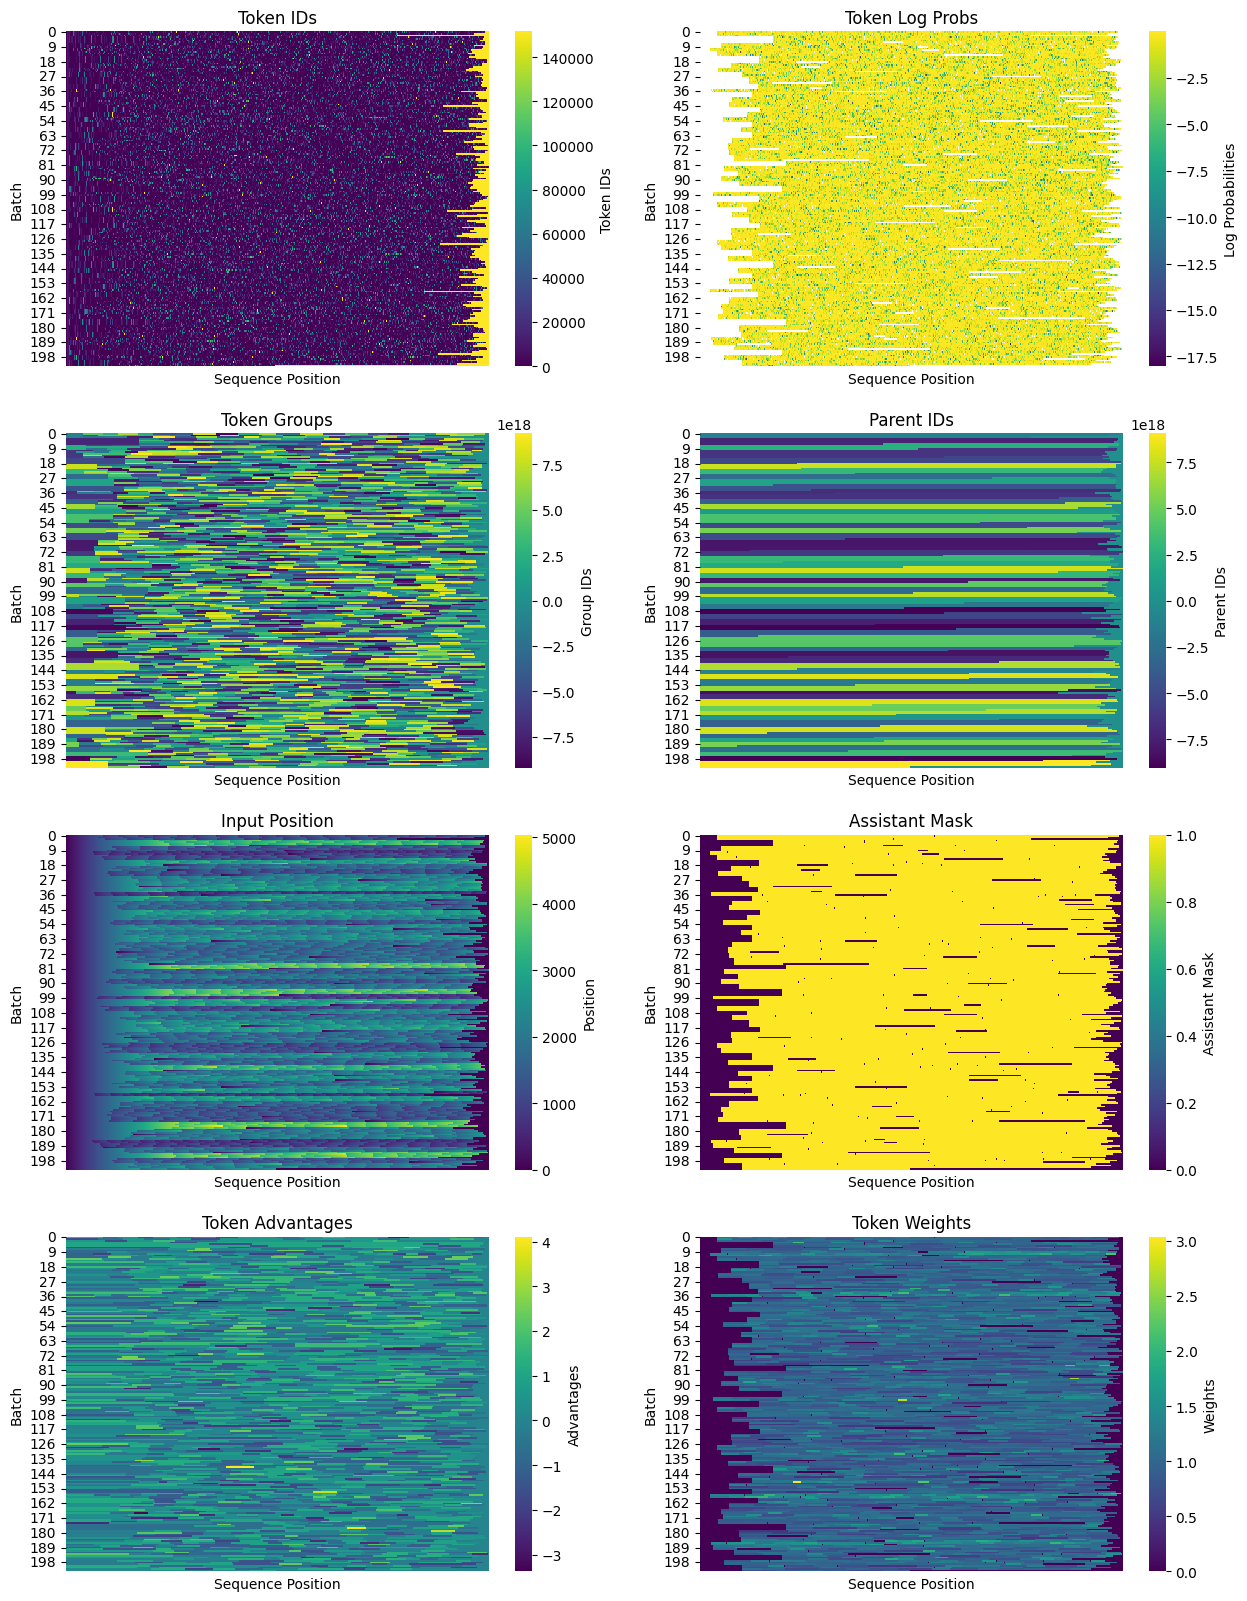

In [31]:
tokenized_results = [
    result for results in train_results for result in results if result.advantage != 0
]
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results,
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
if verbosity == 2:
    plot_packed_tensors(packed_tensors)
else:
    print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")

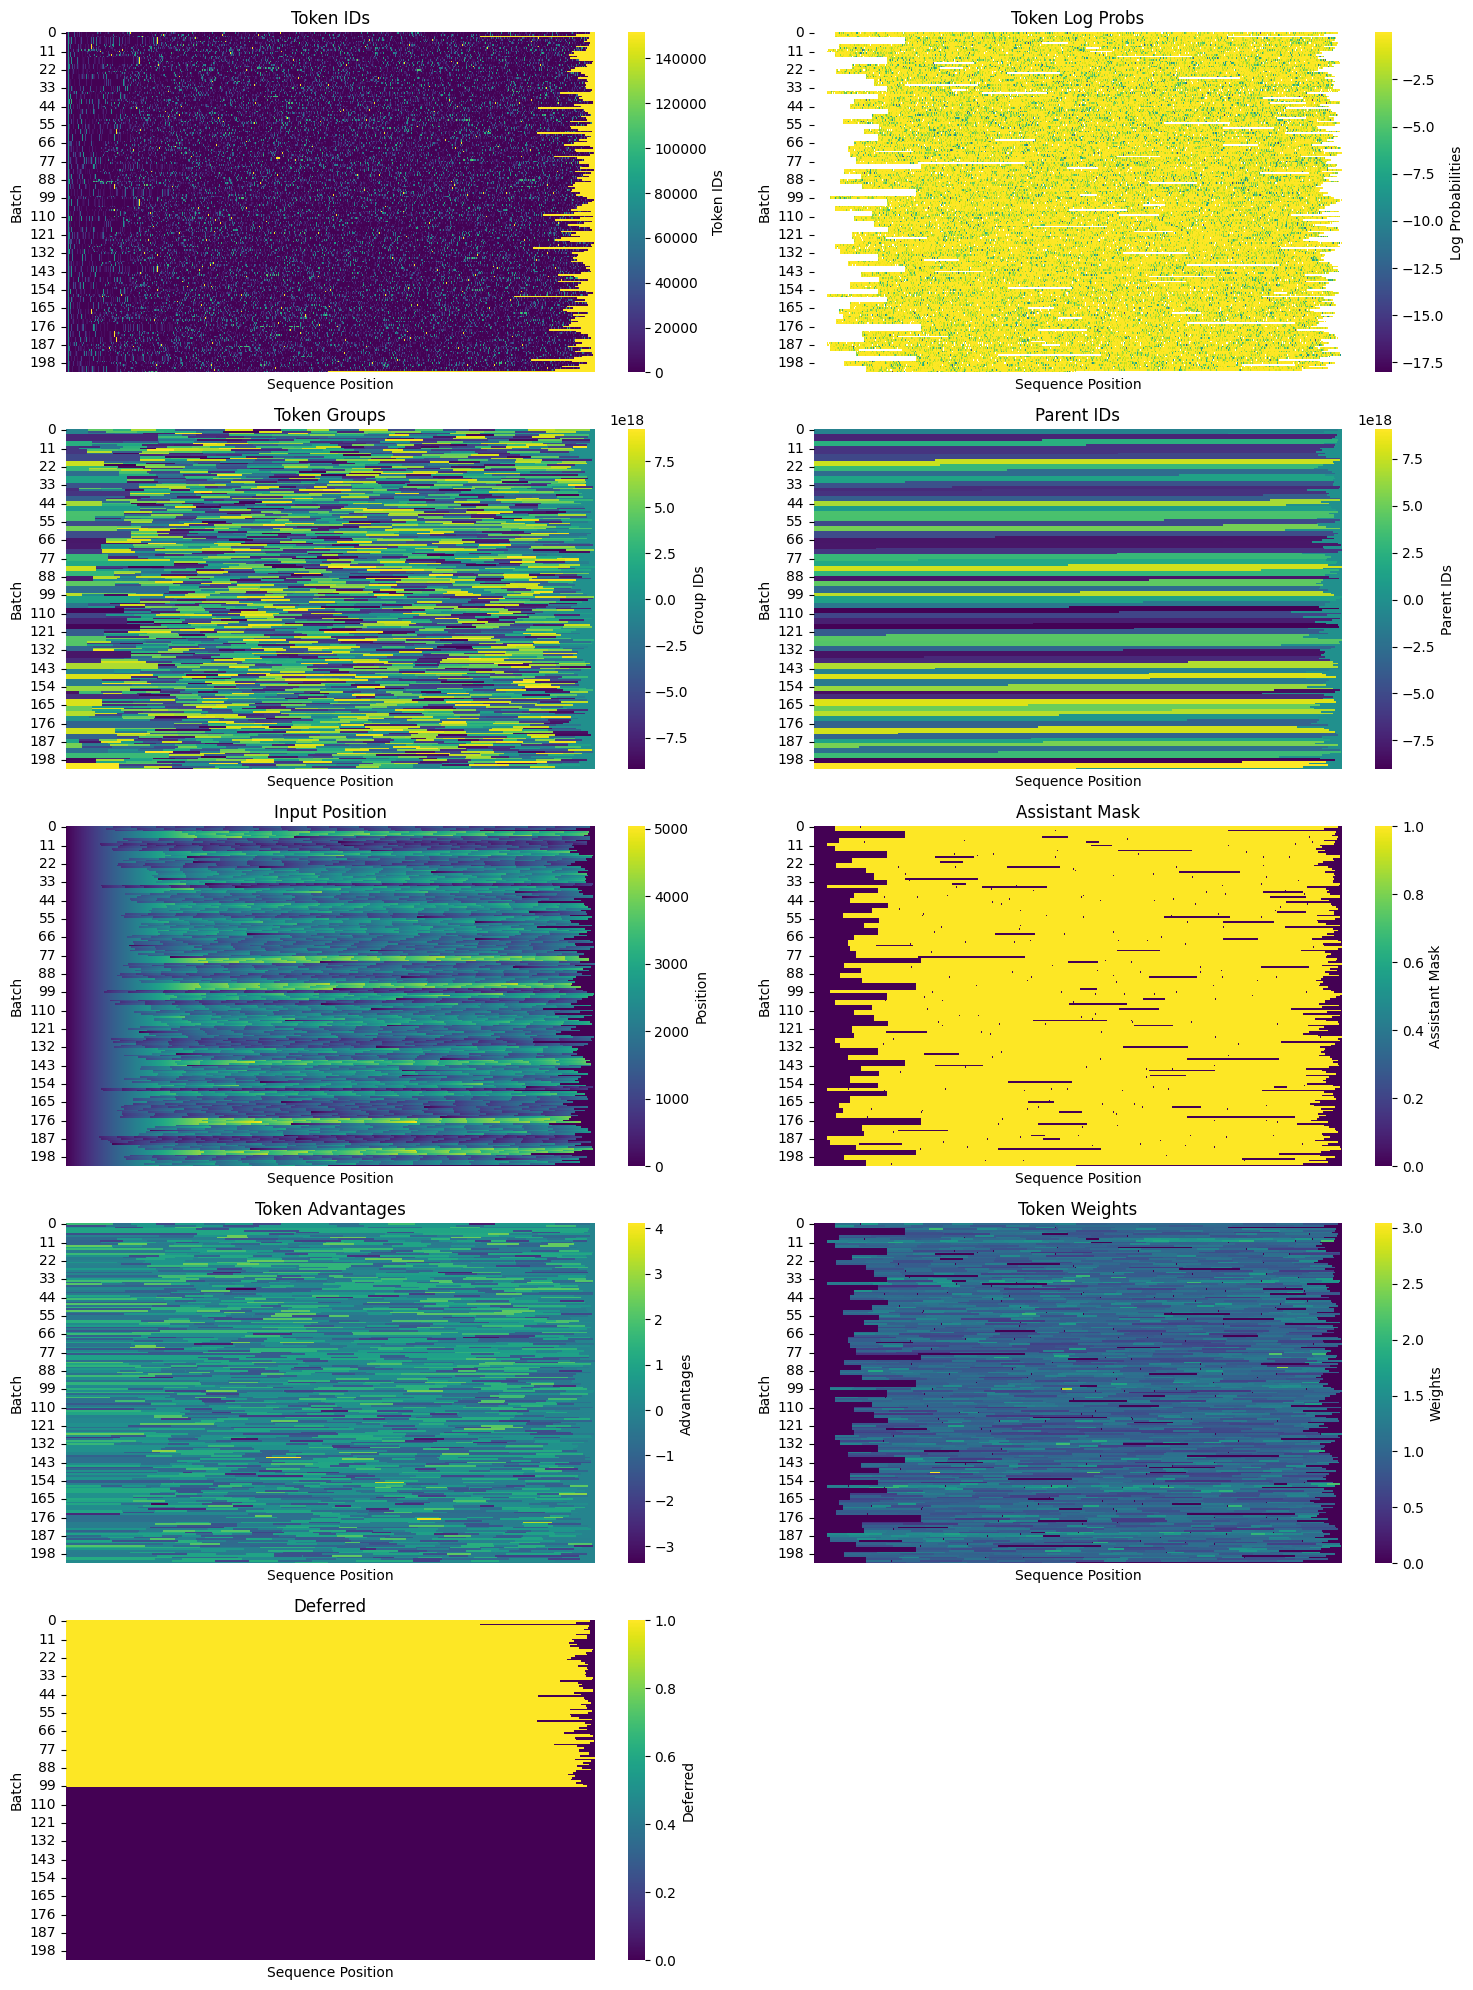

In [32]:
if verbosity == 2:
    plot_packed_tensors(packed_tensors)
else:
    print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")

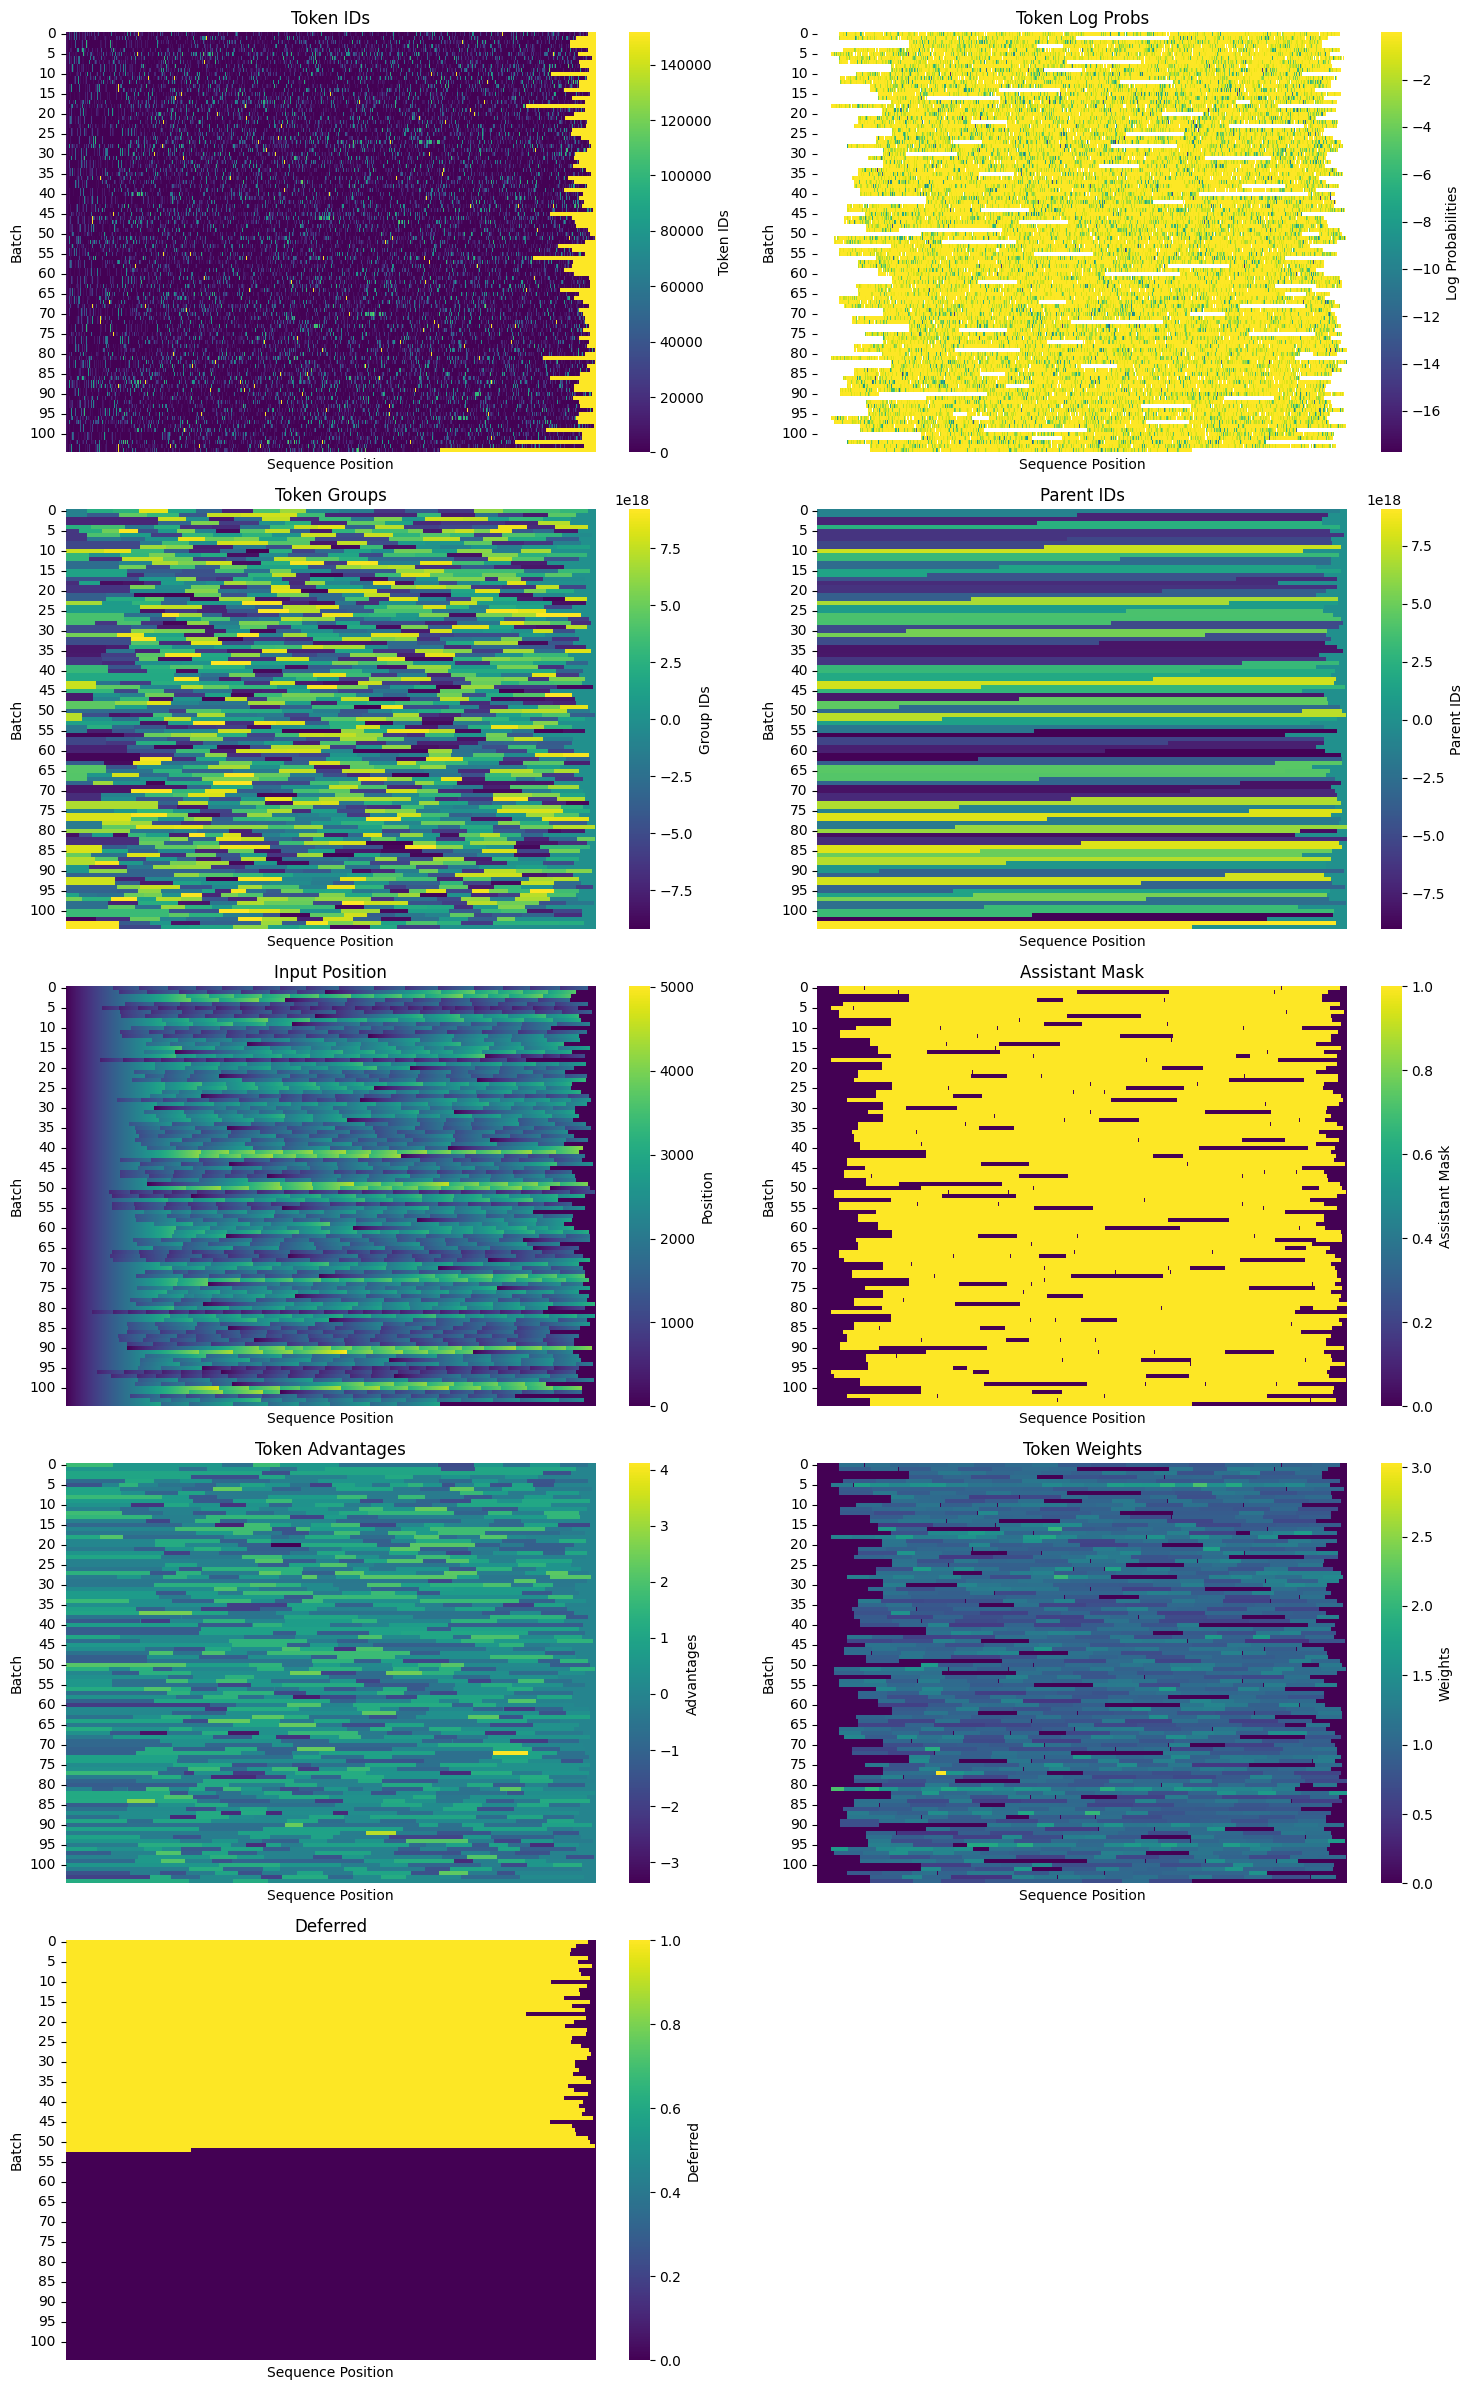

$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/048/config.yaml
Running with torchrun...


W0225 16:02:10.568000 22473 torch/distributed/run.py:793] 
W0225 16:02:10.568000 22473 torch/distributed/run.py:793] *****************************************
W0225 16:02:10.568000 22473 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0225 16:02:10.568000 22473 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/048/0001
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-00008

Writing logs to models/048/logs/log_1740499335.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.01 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|26|Loss: 0.0207: 100%|██████████| 26/26 [12:45<00:00, 28.80s/it, entropy=0.882, kl_div=nan, loss=0.0207, policy=0.0207]       INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

<Task pending name='Task-18334' coro=<rsync_dir() running at /home/gcpuser/sky_workdir/experiments/lib/utils.py:49>>

rsyncing /home/gcpuser/sky_workdir/experiments/models/048 to gs:/atreides/openpipe/models/048


In [39]:
tokenized_results = [
    result for results in train_results for result in results if result.advantage != 0
][::2]
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results,
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
if verbosity == 2:
    plot_packed_tensors(packed_tensors)
else:
    print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
optimizer_config = ComponentConfig(
    model.tune_optimizer,
    lr=lr,
    betas=betas,
    weight_decay=weight_decay,
)
if model.tune_optimizer == "torch.optim.AdamW":
    optimizer_config.fused = True
model_name = await tune(
    base_model=model.base_model,
    output_dir=output_dir,
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=optimizer_config,
        loss=ComponentConfig(
            GRPO,
            clip_epsilon=clip_epsilon,
            entropy_coef=entropy_coef,
            kl_coef=kl_coef,
            tanh=tanh,
        ),
        # shuffle=True,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=model.tune_num_output_chunks,
        compile=True,
    ),
    verbosity=verbosity,
)
# see ./logs/rsync.log for output
asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))

In [40]:
i = 2
vllm = await start_vllm(
    model_name,
    max_concurrent_requests=1024,
    env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=1024,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=240 + 15 * torch.cuda.device_count(),
    verbosity=verbosity,
)
semaphore = asyncio.Semaphore(int(1.33 * vllm.max_concurrent_tokens / expected_tokens))
offset = i * stride
val_results, train_results = await asyncio.gather(
    get_task_results(
        tasks=val_tasks,
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=8,
        n=2,
        on_chunk=inference_early_stop,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="val",
        semaphore=semaphore,
    ),
    get_task_results(
        tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=False,
        n=samples_per_task,
        on_chunk=inference_early_stop,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="train",
        semaphore=semaphore,
        transform=TaskResultTokenizer(tokenizer),
    ),
)
vllm.process.terminate()
kill_vllm_workers()
val_stats = val_results.stats
assert val_stats.grades > 0
assert val_stats.usages > 0
wandb_data = {
    "iteration": i,
    "exceptions": val_stats.exceptions + train_results.stats.exceptions,
    "reward": val_stats.total_reward / val_stats.grades,
    "tokens": round(val_stats.completion_tokens / val_stats.usages),
}
for metric in val_stats.total_metrics:
    wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
try:
    wandb_data.update(
        pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
    )
except Exception:
    pass
wandb.log(wandb_data)
expected_tokens = wandb_data["tokens"]
try:
    best_iteration = (
        wandb.Api()
        .run(f"{run.entity}/{run.project}/{run.id}")
        .history()
        .sort_values(by="reward")["iteration"]
        .iloc[-1]
    )
    clear_iteration_dirs(output_dir, [best_iteration, i])
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
except Exception:
    pass
# Deferred results
train_results, deferred_results = (
    train_results[: len(train_results) // 2],
    train_results[len(train_results) // 2 :],
)

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/048/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/048/0002 --port=8000 --api-key=default
INFO 02-25 16:17:28 __init__.py:190] Automatically detected platform cuda.
INFO 02-25 16:17:29 api_server.py:840] vLLM API server version 0.7.2
INFO 02-25 16:17:29 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/048/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.57it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.61it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.62it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.20it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.18it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.95it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.82it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.75it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.82it/s]



(VllmWorkerProcess pid=25568) INFO 02-25 16:17:48 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-25 16:17:48 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=25568) INFO 02-25 16:17:51 worker.py:267] Memory profiling takes 2.97 seconds
(VllmWorkerProcess pid=25568) INFO 02-25 16:17:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=25568) INFO 02-25 16:17:51 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-25 16:17:51 worker.py:267] Memory profiling takes 3.05 seconds
INFO 02-25 16:17:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-25 16:17:51 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [25275]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-25 16:18:40 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:56920 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [07:44<00:00,  9.97it/s, completion_tokens=859, prompt_tokens=1267, reward=0.334, acc=0.334, early_stop=0.00688, token_logprobs=2747260]
Deleted iteration directory ./models/048/0001
rsyncing /home/gcpuser/sky_workdir/experiments/models/048 to gs:/atreides/openpipe/models/048


In [42]:
_deferred_results, _train_results = prev_deferred_results[0], train_results[0]
display(len(_deferred_results), len(_train_results))
mean_reward = torch.tensor([result.reward for result in _train_results]).mean().item()
display(mean_reward)

50

50

0.20250000059604645

In [43]:
differences = [mean_reward - result.reward for result in _deferred_results]
std_dev = torch.std(torch.tensor(differences)).item()
std_dev

0.1340118795633316

In [45]:
torch.mean(torch.abs(torch.tensor(differences) / std_dev))

tensor(0.8350)

In [25]:
torch.tensor([result.reward for result in _deferred_results]).mean().item()

0.025714287534356117

In [24]:
_deferred_results[1].chat.split("<|im_end|>")[1] == _train_results[0].chat.split("<|im_end|>")[1]

True

In [46]:
if prev_deferred_results is not None:
    for _deferred_results, _train_results in zip(prev_deferred_results, train_results):
        mean_reward = (
            torch.tensor([result.reward for result in _train_results]).mean().item()
        )
        differences = [mean_reward - result.reward for result in _deferred_results]
        std_dev = torch.std(torch.tensor(differences)).item()
        for result, difference in zip(_deferred_results, differences):
            result.advantage = difference / std_dev
            result.deferred = True
    random.shuffle(prev_deferred_results)
    random.shuffle(train_results)
    train_results = prev_deferred_results + train_results
else:
    random.shuffle(train_results)
prev_deferred_results = deferred_results

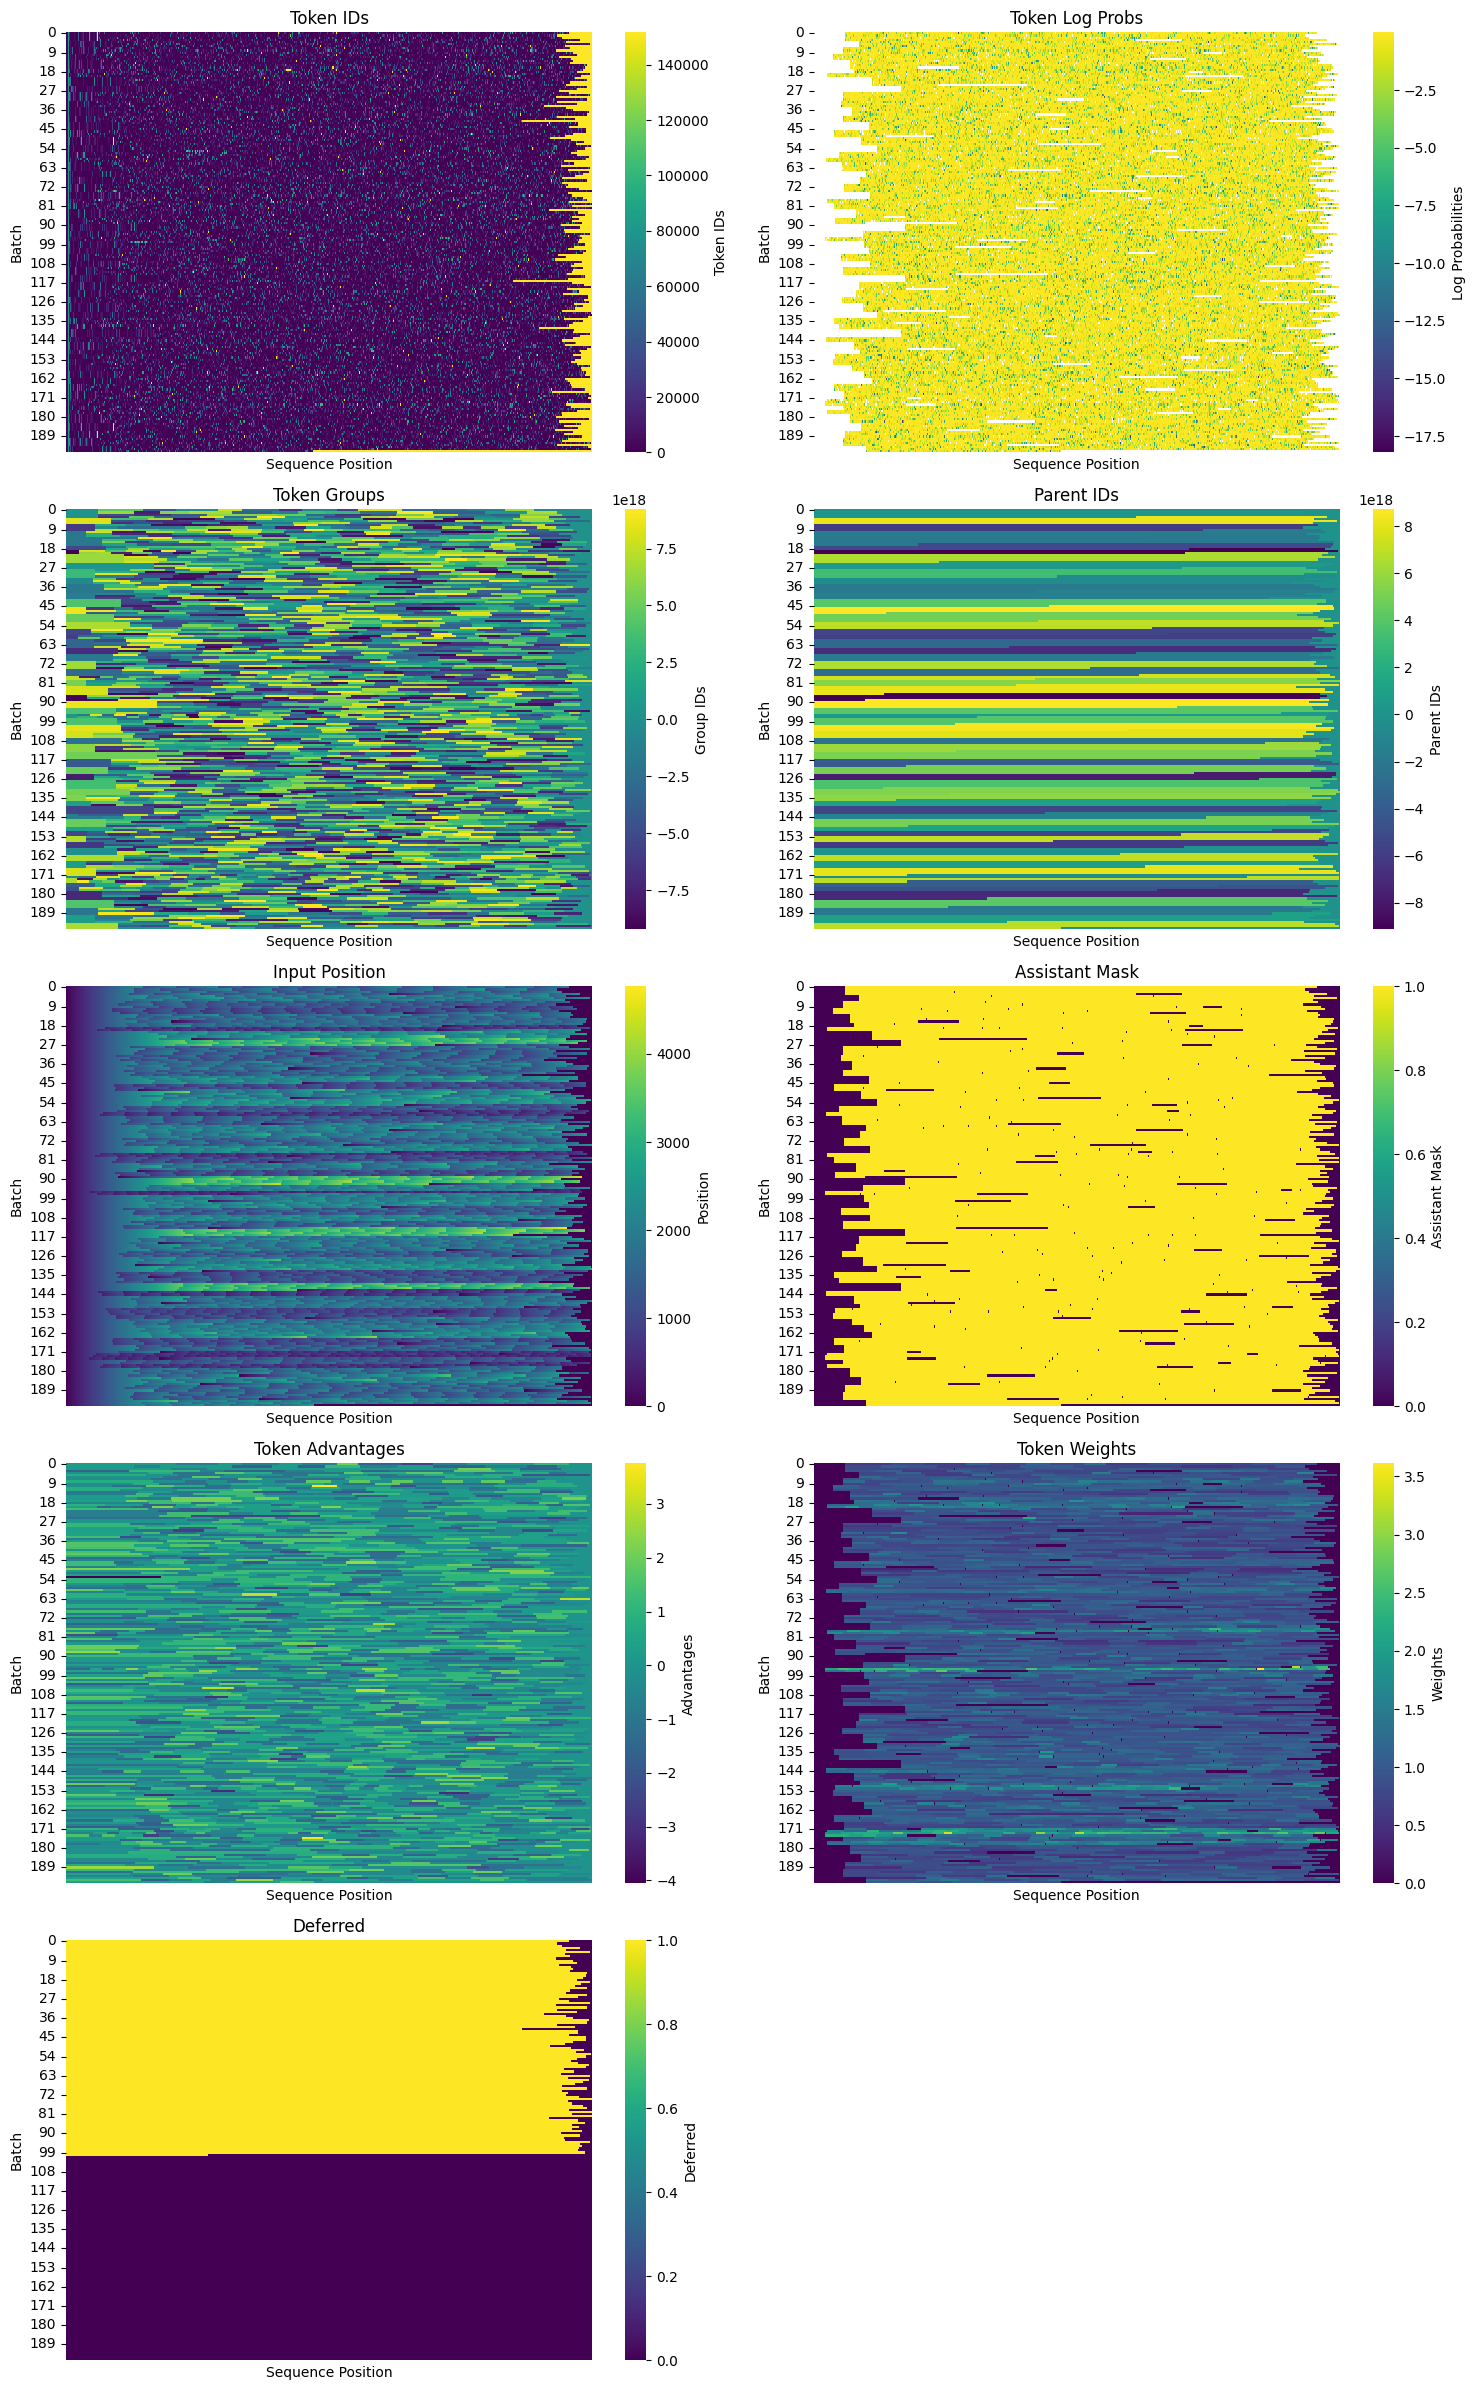

$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/048/config.yaml
Running with torchrun...


W0225 16:29:42.508000 28458 torch/distributed/run.py:793] 
W0225 16:29:42.508000 28458 torch/distributed/run.py:793] *****************************************
W0225 16:29:42.508000 28458 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0225 16:29:42.508000 28458 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/048/0002
  checkpoint_files:
  - ft-model-00004-of-00008.safetensors
  - ft-model-00002-of-00008.safetensors
  - ft-model-00003-of-00008.safetensors
  - ft-model-00008-of-00008

Writing logs to models/048/logs/log_1740500987.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.44 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|11|Loss: 0.0015:  22%|██▏       | 11/49 [05:32<18:18, 28.90s/it, entropy=0.79, kl_div=nan, loss=0.00145, policy=0.00145]  

In [ ]:
tokenized_results = [
    result for results in train_results for result in results if result.advantage != 0
]
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results,
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
if verbosity == 2:
    plot_packed_tensors(packed_tensors)
else:
    print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
optimizer_config = ComponentConfig(
    model.tune_optimizer,
    lr=lr,
    betas=betas,
    weight_decay=weight_decay,
)
if model.tune_optimizer == "torch.optim.AdamW":
    optimizer_config.fused = True
model_name = await tune(
    base_model=model.base_model,
    output_dir=output_dir,
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=optimizer_config,
        loss=ComponentConfig(
            GRPO,
            clip_epsilon=clip_epsilon,
            entropy_coef=entropy_coef,
            kl_coef=kl_coef,
            tanh=tanh,
        ),
        # shuffle=True,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=model.tune_num_output_chunks,
        compile=True,
    ),
    verbosity=verbosity,
)
# see ./logs/rsync.log for output
asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
# prev_deferred_results: list[list[TokenizedResult]] | None = None or []
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=240 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
        # see ./logs/rsync.log for output
        asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
    except Exception:
        pass
    # Deferred results
    train_results, deferred_results = (
        train_results[: len(train_results) // 2],
        train_results[len(train_results) // 2 :],
    )
    if prev_deferred_results is not None:
        for _deferred_results, _train_results in zip(prev_deferred_results, train_results):
            mean_reward = (
                torch.tensor([result.reward for result in _train_results]).mean().item()
            )
            differences = [mean_reward - result.reward for result in _deferred_results]
            std_dev = torch.std(torch.tensor(differences)).item()
            for result, difference in zip(_deferred_results, differences):
                result.advantage = difference / std_dev
                result.deferred = True
        random.shuffle(prev_deferred_results)
        random.shuffle(train_results)
        train_results = prev_deferred_results + train_results
    else:
        random.shuffle(train_results)
    prev_deferred_results = deferred_results
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
            compile=True,
        ),
        verbosity=verbosity,
    )
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))